<h1>Continuum subtraction - MaNGA cube</h1>

Example of use of slicing, multi-dimension arithmetic, and smoothing.

In [144]:
# All imports used in this script
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.io import fits
from __future__ import print_function

import numpy.ma as ma
from scipy.ndimage import gaussian_filter
from scipy.interpolate import UnivariateSpline, LSQUnivariateSpline, InterpolatedUnivariateSpline, interp1d, PiecewisePolynomial

from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel

# not using these, but import just to show what is available.
from astropy.convolution import Box2DKernel, MexicanHat2DKernel, Ring2DKernel,TrapezoidDisk2DKernel

%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 10

<h3>1 - Get raw data cube</h3>

Read cube from FITS file.

Ensure all NaN-valued pixels are zeroed before proceeding.

In [95]:
cube = fits.getdata('./data/manga-7443-12703-LOGCUBE.fits')
print(cube.shape)
cube[np.where(np.isnan(cube))] = 0.

(4563, 74, 74)


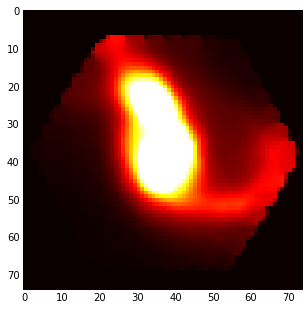

In [96]:
plt.rcParams['figure.figsize'] = 5,5
fig, ax = plt.subplots()
ax.imshow(np.sum(cube,axis=0), vmax=2000, cmap=cm.hot, interpolation='nearest')

<h3>2 - Find emission</h3>

To maximize SNR, build sum from entire cube along wavelength dimension.

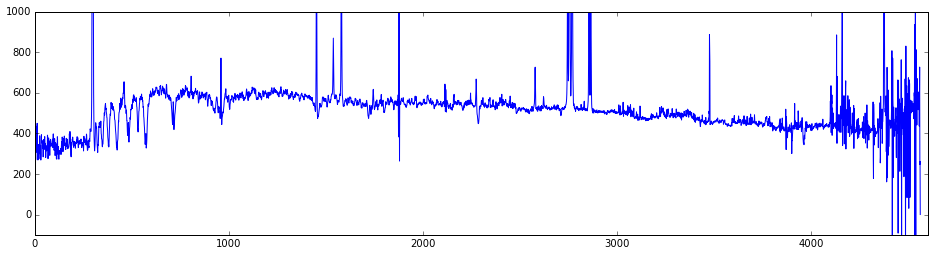

In [109]:
summed = np.sum(cube, axis=2)
summed = np.sum(summed, axis=1)

plt.gcf().set_size_inches(16.,4.)
plt.axis([0.,4600.,-100.,1000.])
plt.plot(summed)

<h3>3 - Mask out emission region </h3>

1 - Build mask that rejects wavelength ranges with emission.

2 - Use mask to build a masked data cube.

In [98]:
mask = cube.copy()
mask.fill(False)
mask[ 240: 600,:,:] = True  # these were determined by examining the plot above with a large
mask[ 670: 730,:,:] = True  # zoom factor. Some interaction is unavoidable here.
mask[ 900:1000,:,:] = True  
mask[1400:1600,:,:] = True  
mask[1870:1900,:,:] = True  
mask[2070:2100,:,:] = True  
mask[2250:2310,:,:] = True  
mask[2560:2590,:,:] = True  
mask[2700:2900,:,:] = True  
mask[3450:3500,:,:] = True  
mask[3800:4000,:,:] = True  
mask[4050:4300,:,:] = True  
mask[4310:4563,:,:] = True  

masked_cube = ma.masked_array(cube, mask=mask)

<h3>4 - Verify that masked data cube is OK </h3>

Again, build sum for entire *masked* cube. Data in masked wavelength ranges should be absent.

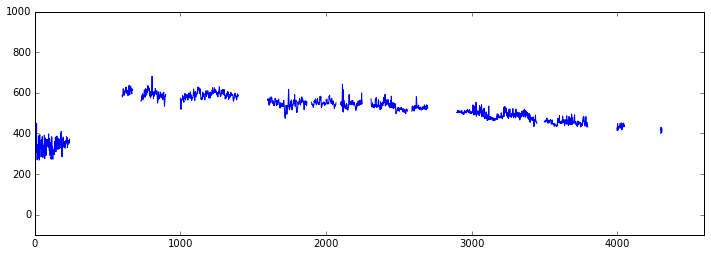

In [99]:
summed_masked = np.sum(masked_cube, axis=2)
summed_masked = np.sum(summed_masked, axis=1)

plt.gcf().set_size_inches(12.,4.)
plt.axis([0.,4600.,-100.,1000.])
plt.plot(summed_masked)

<h3>5 - Build 1-D continuum model by smoothing summed masked spectrum </h3>

<h4>Stuck here: scipy interpolation routines do not seem to work well with masked arrays for our specific problem.</h4>

we want then to fill the masked-out gaps with interpolated data, but they just seem to ignore the data entirely and fill the gaps with zeros. 




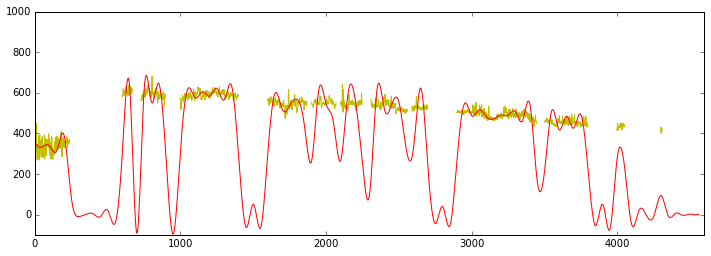

In [148]:
x = np.asarray(range(len(summed_masked)))

nodes = range(1,4563,50)    # set spline nodes 50 spectral pixels apart
continuum = LSQUnivariateSpline(x, summed_masked, nodes)(x)

# nodes = (ma.masked_array(x, mask=mask[:,0,0]))
# continuum = LSQUnivariateSpline(x, summed_masked, nodes)(x)

# continuum = interp1d(x, summed_masked, kind='cubic')(x)

# continuum = PiecewisePolynomial(x, summed)(x)




plt.gcf().set_size_inches(12.,4.)
plt.axis([0.,4600.,-100.,1000.])
plt.plot(summed_masked, 'y')
plt.plot(continuum, 'r')